This code is based on an assignment from the University of Michigan's Coursera course titled Applied Machine Learning in Python. I have expanded on the assignment a bit, adding different kinds of classifiers, ROC curves, performance assessments, etc.

Skills demonstrated: classification, scikit-learn, TensorFlow, model evaluation, general coding

This code trains one or more classifiers to assess how engaging videos from a dataset are based on seven features defined below. A video is classified as "engaging" if the median percentage of the video watched across all viewers was at least 30%.

Dataset: engagement_data.csv:

Features:

1. title_word_count - the number of words in the title of the video.

2. document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.

3. freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.

4. easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.

5. fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.

6. speaker_speed - The average speaking rate in words per minute of the presenter in the video.

7. silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).

Target variable:

1. engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def data_prep():
    
    df = pd.read_csv('engagement_data.csv')
    df.set_index('id', inplace = True)
    df.drop(['normalization_rate'], axis = 1, inplace=True)
    X = df.copy().drop(['engagement'], axis = 1)
    y = df['engagement']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    
    #print(y_train)
    
    #The features size can vary by several orders of magnitude between features, so we'll normalize
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns)
    X_test_std_df = pd.DataFrame(X_test_std, columns = X_test.columns)
    
    return X_train_std_df, X_test_std_df, y_train, y_test
X_train_std, X_test_std, y_train, y_test = data_prep()

In [3]:
'''
The function returns 
    1. rec - a Series with values y_prob, indexed by the video ID
    2. clf - the fitted SVC classifier

Set search = True to determine best parameters using GridSearchCV. If search = False, then the classifier is
parameterized with the optimal C and gamma values determined from a prior GridSearchCV. Setting search to False saves
a substantial amount of time.

'''
def engagement_model_SVM(X_train, X_test, y_train, y_test, search = False):
    from sklearn.svm import SVC
    if search == True:
        svc = SVC(random_state=0,probability=True)
        # NOTE: could also include other SVC kernels in the params dictionary, 
        # but this code is primarily for illustrative purposes and adding more parameters
        # adds much more time to the grid search
        params = {'C':[0.001, 0.01, 0.1, 1], 'gamma':[0.001, 0.01, 0.1, 1]} 
        clf = GridSearchCV(svc, params, scoring = 'roc_auc')
    else:
        clf = SVC(C = 0.1, gamma = 0.01, random_state=0, probability=True)
    clf.fit(X_train, y_train)
    #params = clf.best_params_
    y_prob = clf.predict_proba(X_test)[:,1]
    
    rec = pd.Series(y_prob, index=y_test.index)
    #raise NotImplementedError()
    return rec, clf
rec_svc, svc = engagement_model_SVM(X_train_std, X_test_std, y_train, y_test)

In [4]:
'''
The function returns 
    1. rec - a Series with values y_prob, indexed by the video ID
    2. clf - the fitted LogisticRegression classifier
    3. X_train.columns - the feature names (for plotting purposes)
    4. coefs - the coefficients from the fitted logistic regression model to assess feature importance

Set search = True to determine best parameters using GridSearchCV. If search = False, then the classifier is
parameterized with the optimal C value determined from a prior GridSearchCV. Setting search to False saves
a substantial amount of time.

'''
def engagement_model_logReg(X_train, X_test, y_train, y_test, search = False):
    from sklearn.linear_model import LogisticRegression as LR
    
    if search == True:
        lr = LR(random_state=0)
        params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]} 
        clf = GridSearchCV(lr, params, scoring = 'roc_auc')
        clf.fit(X_train_std, y_train)
        print(clf.best_params_)
        coefs = None
    else:
        clf = LR(C = 0.1, random_state=0)
        clf.fit(X_train, y_train)
        coefs = clf.coef_[0]
    
    y_prob = clf.predict_proba(X_test)[:,1]
    
    rec = pd.Series(y_prob, index = y_test.index)
    #print(rec)
    #raise NotImplementedError()
    return rec, clf, X_train.columns, coefs
rec_lr, lr, cols, coefs = engagement_model_logReg(X_train_std, X_test_std, y_train, y_test)
#print(coefs)

With a linear model (or linear kernel, in the case of SVMs), we can assess the importance of each feature by looking at the magnitude of each coefficient in the model fitted from the data:

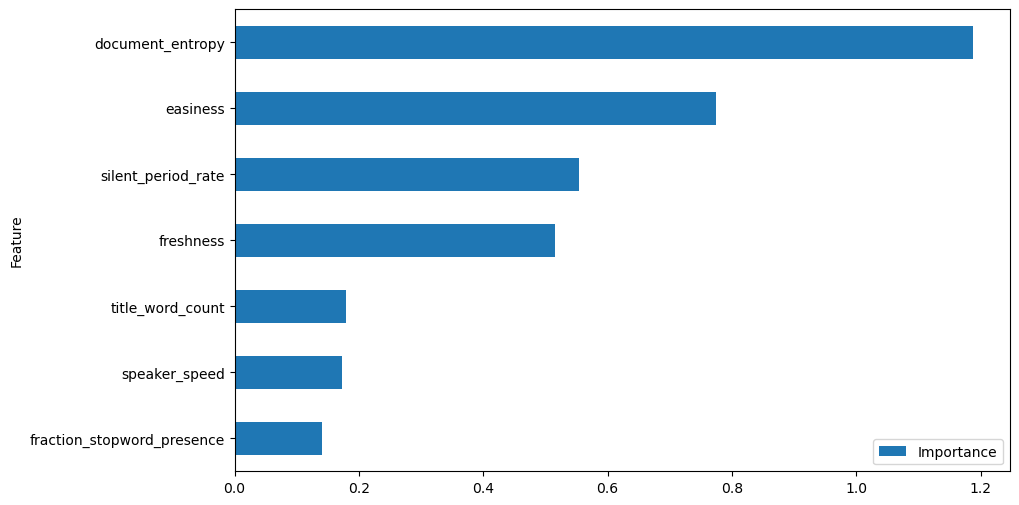

In [5]:
if (coefs is not None):
    feature_importance = pd.DataFrame({'Feature': cols, 'Importance': np.abs(coefs)}).sort_values('Importance')
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

From the above figure, we can see that document_entropy (a measue of the number of topics covered in the video) and easiness (simpler language) tend to influence viewer engagement more than speaker_speed and fraction_stopword_presence (fraction of common words like "the" and "and").

In [6]:
'''
The function returns 
    1. rec - a Series with values y_prob, indexed by the video ID
    2. model - the fitted LogisticRegression classifier

'''
def engagement_model_NN(X_train, X_test, y_train, y_test):
    import tensorflow as tf
    from keras import Sequential
    from keras.losses import BinaryCrossentropy
    from keras.metrics import AUC
    from keras.layers import Dense
    from keras.optimizers import Adam
    
    tf.keras.utils.set_random_seed(0)
    
    df = pd.read_csv('engagement_data.csv')
    df.set_index('id', inplace = True)
    df.drop(['normalization_rate'], axis = 1, inplace=True)
    #print(df.head())
    X = df.copy().drop(['engagement'], axis = 1)
    y = df['engagement']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    model = Sequential(
    [
        Dense(16, activation="relu", name="layer1"),
        Dense(32, activation="relu", name="layer2"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid", name="layer3"),
    ]
    )
    
    model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=[AUC()])
    model.fit(X_train_std,y_train,validation_data=(X_test_std,y_test),batch_size=100,epochs=25)

    score=model.evaluate(X_test_std,y_test,verbose=0)
    print(score[1])
    
    y_prob = model.predict(X_test_std)
    

    rec = pd.Series(tf.reshape(y_prob,[len(y_prob)]), index = y_test.index)
    #print(rec)
    #raise NotImplementedError()
    return rec, model
rec_NN, NN = engagement_model_NN(X_train_std, X_test_std, y_train, y_test)
#print(rec_NN)

2023-09-06 15:19:43.173822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
70/70 [==============================] - 1s 5ms/step - loss: 0.4223 - auc: 0.5543 - val_loss: 0.2972 - val_auc: 0.7306
Epoch 2/25
70/70 [==============================] - 0s 3ms/step - loss: 0.2576 - auc: 0.8050 - val_loss: 0.2470 - val_auc: 0.8320
Epoch 3/25
70/70 [==============================] - 0s 2ms/step - loss: 0.2313 - auc: 0.8452 - val_loss: 0.2376 - val_auc: 0.8464
Epoch 4/25
70/70 [==============================] - 0s 2ms/step - loss: 0.2188 - auc: 0.8546 - val_loss: 0.2279 - val_auc: 0.8584
Epoch 5/25
70/70 [==============================] - 0s 2ms/step - loss: 0.2105 - auc: 0.8650 - val_loss: 0.2228 - val_auc: 0.8671
Epoch 6/25
70/70 [==============================] - 0s 2ms/step - loss: 0.2055 - auc: 0.8696 - val_loss: 0.2195 - val_auc: 0.8711
Epoch 7/25
70/70 [==============================] - 0s 2ms/step - loss: 0.2014 - auc: 0.8765 - val_loss: 0.2152 - val_auc: 0.8725
Epoch 8/25
70/70 [==============================] - 0s 3ms/step - loss: 0.1971 - auc: 0.88

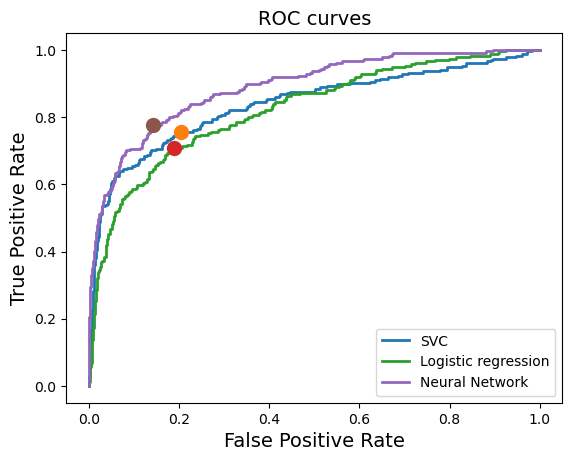

In [8]:
# Plot the ROC curve for each classifier above and return the probability threshold value that minimizes the Euclidean
# distance to fpr = 0, tpr = 1, thereby optimizing the fpr-tpr tradeoff
def roc_plotter(y_test, y_prob, clf_type):
    from sklearn.metrics import roc_curve
    from numpy import where, abs, argmin
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, linewidth = 2, label = clf_type)
    
    # determine probability threshold that minimizes the distance to (fpr,tpr)=(0,1), 
    # which is the optimal threshold in the sense of tpr-fpr tradeoff
    dist = fpr**2 + (tpr-1)**2
    ind = argmin(dist)
    x0, y0, thresh = fpr[ind], tpr[ind], thresholds[ind]
    
    plt.plot(x0, y0, 'o', markersize = 10)#, label = f'Threshold {thresh:.3f}')
    plt.legend()
    plt.title('ROC curves', size = 14)
    plt.xlabel('False Positive Rate', size = 14)
    plt.ylabel('True Positive Rate', size = 14)
    return thresh
svc_thresh = roc_plotter(y_test,rec_svc,'SVC')
lr_thresh = roc_plotter(y_test,rec_lr,'Logistic regression')
nn_thresh = roc_plotter(y_test,rec_NN,'Neural Network')

In [10]:
#print(y_pred > 0.1)
svc_auc = roc_auc_score(y_test, rec_svc)
svc_acc = accuracy_score(y_test, (rec_svc > svc_thresh))
lr_auc = roc_auc_score(y_test, rec_lr)
lr_acc = accuracy_score(y_test, (rec_lr > lr_thresh))
nn_auc = roc_auc_score(y_test,rec_NN)
nn_acc = accuracy_score(y_test,(rec_NN > nn_thresh))

print('We can compare the AUC and accuracy scores of each model:')

print(f'SVC AUC score: {svc_auc:.3f}')
print(f'SVC accuracy score at optimal probability threshold: {svc_acc:.3f}')

print(f'LogisticRegression AUC score: {lr_auc:.3f}')
print(f'LogisticRegression accuracy score at optimal probability threshold: {lr_acc:.3f}')

print(f'Neural network AUC score: {nn_auc:.3f}')
print(f'Neural network accuracy score at optimal probability threshold: {nn_acc:.3f}')


We can compare the AUC and accuracy scores of each model:
SVC AUC score: 0.840
SVC accuracy score at optimal probability threshold: 0.792
LogisticRegression AUC score: 0.824
LogisticRegression accuracy score at optimal probability threshold: 0.800
Neural network AUC score: 0.891
Neural network accuracy score at optimal probability threshold: 0.850
